# Machine Learning

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import re
import statistics
import seaborn as sns
import math
from scipy import stats
import glob
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
import matplotlib.pyplot as plt

### Import Data

In [2]:
path = ('../../capstone_project_1/data/')

In [3]:
#Rate Data
df = pd.read_csv(path + 'ml-data.csv')

In [4]:
df.shape

(151, 16)

In [5]:
df = df.set_index('Player')

In [6]:
df

,Rate_NFL,Y/A_NFL,win_pct,AY/A_College,Att_College,Cmp_College,G_College,Int_College,Pct,Rate_College,TD_College,Y/A_College,Yds_College,above_nfl_ypa,above_nfl_rate
Player,,,,,,,,,,,,,,,
A.J. Feeley,66.1,6.2,0.466667,7.6,259,136,10,6,52.5,129.0,14,7.5,1951,0,0
A.J. McCarron,97.1,7.2,0.666667,9.6,978,656,40,15,67.1,163.3,74,8.8,8630,1,1
Aaron Brooks,77.5,6.8,0.422222,8.1,560,320,22,16,57.2,139.7,32,8.2,4601,0,0
Aaron Rodgers,102.7,7.8,0.653179,8.6,665,424,25,13,63.8,150.4,43,8.2,5469,1,1
Akili Smith,54.2,5.0,0.200000,8.8,571,323,23,15,56.0,147.0,45,8.5,5148,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Troy Smith,77.8,8.1,0.500000,9.7,548,352,24,10,64.1,162.3,46,8.9,4824,1,0
Tyler Palko,59.8,5.9,0.250000,8.0,1072,643,35,25,60.4,141.7,66,7.8,8330,0,0
Tyrod Taylor,92.8,7.2,0.523810,9.6,558,324,27,10,57.8,152.1,37,9.1,5054,1,1


## YPA Modeling

### Set Features/Target for YPA. Assign Training and Testing Data.

Training Data - Quarterbacks Drafted between 1999-2015. \
Testing Data - Quarterbacks Drafted between 2016-2019.

In [7]:
features = ['AY/A_College', 'Att_College','Cmp_College', 'G_College', 'Int_College','Pct','Rate_College','TD_College','Y/A_College','Yds_College']
test_qbs = ['Baker Mayfield', 'C.J. Beathard', 'Cody Kessler', 'Dak Prescott', 'Daniel Jones', 'David Blough', 'Deshaun Watson', 'Drew Lock', 'Dwayne Haskins', 'Gardner Minshew', 'Jacoby Brissett', 'Jared Goff', 'Jeff Driskel', 'Josh Allen', 'Josh Rosen', 'Kyle Allen', 'Kyler Murray', 'Lamar Jackson', 'Mason Rudolph', 'Nick Mullens', 'Patrick Mahomes', 'Sam Darnold']

In [8]:
df_train = df.drop(test_qbs)

In [9]:
X_train = df_train.loc[:, features]
y_train = df_train.loc[:, 'above_nfl_ypa']

In [10]:
df_test = df.loc[test_qbs, :]

In [11]:
X_test = df_test.loc[:, features]
y_test = df_test.loc[:, 'above_nfl_ypa']

### DummyClassifier

In [12]:
from sklearn.dummy import DummyClassifier

#Most Frequent
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy_score_ypa = dummy.score(X_train, y_train)
print(dummy.score(X_train, y_train))

0.6046511627906976


Goal is to have better than 60.5% accuracy in model. 

### Logistic Regression

In [13]:
#all ten features
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(solver='liblinear')

#3 fold
scores3 = cross_val_score(logreg, X_train, y_train, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3))
cv3_logreg_1 = scores3.mean()
print('3 fold mean scores ' + str(cv3_logreg_1))

print('=' * 100)

#5 fold
scores5 = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5))
cv5_logreg_1 = scores5.mean()
print('5 fold mean scores ' + str(cv5_logreg_1))

3 fold scores [0.76744186 0.62790698 0.6744186 ]
3 fold mean scores 0.689922480620155
5 fold scores [0.73076923 0.65384615 0.69230769 0.73076923 0.68      ]
5 fold mean scores 0.6975384615384616


Fairly good results, but this is ignoring multicollinearity. Will reduce feature with high Variance Inflation Factor.

### Multicollinearity

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=50):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]]

In [15]:
calculate_vif_(X_train)

dropping 'Rate_College' at index: 6
dropping 'Y/A_College' at index: 7
dropping 'Yds_College' at index: 7
dropping 'Att_College' at index: 1
dropping 'Pct' at index: 4
dropping 'Cmp_College' at index: 1
Remaining variables:
Index(['AY/A_College', 'G_College', 'Int_College', 'TD_College'], dtype='object')


,AY/A_College,G_College,Int_College,TD_College
Player,,,,
A.J. Feeley,7.6,10,6,14
A.J. McCarron,9.6,40,15,74
Aaron Brooks,8.1,22,16,32
Aaron Rodgers,8.6,25,13,43
Akili Smith,8.8,23,15,45
...,...,...,...,...
Troy Smith,9.7,24,10,46
Tyler Palko,8.0,35,25,66
Tyrod Taylor,9.6,27,10,37


In [16]:
features_new = ['AY/A_College', 'G_College', 'Int_College', 'TD_College']
X_train_new = X_train.loc[:, features_new]

Now Perform Logistic Regression With Reduced Features.

In [17]:
logreg2 = LogisticRegression(solver='liblinear')

#3 fold
scores3_new = cross_val_score(logreg2, X_train_new, y_train, cv=3, scoring = 'accuracy')

print('3 fold scores ' + str(scores3_new))
cv3_logreg_2 = scores3_new.mean()
print('3 fold mean scores ' + str(cv3_logreg_2))

print('='*100)

#5 fold
scores5_new = cross_val_score(logreg, X_train_new, y_train, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5_new))
cv5_logreg_2 = scores5_new.mean()
print('5 fold mean scores ' + str(cv5_logreg_2))

3 fold scores [0.6744186  0.69767442 0.62790698]
3 fold mean scores 0.6666666666666666
5 fold scores [0.69230769 0.73076923 0.73076923 0.65384615 0.56      ]
5 fold mean scores 0.6735384615384615


Decent results. Will now fit all of training data and score testing data. 

In [18]:
#New Test Data
X_test_new = X_test.loc[:, features_new]

In [19]:
logreg2.fit(X_train_new, y_train)
logreg2_score = logreg2.score(X_test_new, y_test)
logreg2_score

0.5

Logistic Regression performs very poorly when predicting test data. Will see if parameter tuning can improve results.

In [20]:
from sklearn.model_selection import GridSearchCV

def grid_search_logreg(X, y):
    param_grid = {'C' : [0.001, 0.1, 1, 10, 100]}
    
    logreg = LogisticRegression(solver='liblinear')
    logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
    
    logreg_cv.fit(X, y)
    
    print(logreg_cv.best_params_)
    print(logreg_cv.best_score_)

In [21]:
grid_search_logreg(X_train_new, y_train)

{'C': 10}
0.6812307692307693


In [22]:
#Logreg with best C
logreg = LogisticRegression(solver='liblinear', C =10)

logreg.fit(X_train_new, y_train)
logreg3_test_score = logreg.score(X_test_new, y_test)
logreg3_test_score

0.5

Same score. Will move on to trying DecisionTreeClassifier.

### DecisionTree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [24]:
#out of the box
clf = DecisionTreeClassifier()

#3 fold
scores3 = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3))
cv3_dt_1 = scores3.mean()
print('3 fold mean scores ' + str(cv3_dt_1))

print('=' * 100)

#5 fold
scores5 = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5))
cv5_dt_1 = scores5.mean()
print('5 fold mean scores ' + str(cv5_dt_1))

3 fold scores [0.51162791 0.69767442 0.60465116]
3 fold mean scores 0.6046511627906976
5 fold scores [0.53846154 0.46153846 0.46153846 0.53846154 0.68      ]
5 fold mean scores 0.536


Poor Scores.

In [25]:
#simple tuning
clf_tune = DecisionTreeClassifier(max_depth=2, criterion='entropy')

#3 fold
scores3 = cross_val_score(clf_tune, X_train, y_train, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3))
cv3_dt_2 = scores3.mean()
print('3 fold mean scores ' + str(scores3.mean()))

print('=' * 100)

#5 fold
scores5 = cross_val_score(clf_tune, X_train, y_train, cv=5, scoring='accuracy')
print('5 fold scores ' + str(scores5))
cv5_dt_2 = scores5.mean()
print('5 fold mean scores ' + str(scores5.mean()))

3 fold scores [0.58139535 0.69767442 0.62790698]
3 fold mean scores 0.6356589147286822
5 fold scores [0.65384615 0.69230769 0.73076923 0.53846154 0.6       ]
5 fold mean scores 0.6430769230769231


Scores improved considerably. Will now get score on test data.

In [26]:
clf_tune.fit(X_train, y_train)
dt_test_score = clf_tune.score(X_test, y_test)
dt_test_score

0.5909090909090909

### Conclusion for YPA

Modeling the YPA using Logistic Regression and Decision Tree models did not provide significantly accurate results. Will try out using Passer Rating as target variable to see if results improve. 

## Passer Rating Modeling

### Set Features and Target for Passer Rating. Assign Training and Testing Data.

In [27]:
#Training
X_train_rate = df_train.loc[:, features]
y_train_rate = df_train.loc[:, 'above_nfl_rate']

In [28]:
#Testing
X_test_rate = df_test.loc[:, features]
y_test_rate = df_test.loc[:, 'above_nfl_rate']

### DummyClassifier

In [29]:
from sklearn.dummy import DummyClassifier

#Most Frequent
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_rate, y_train_rate)
dummy_score_rate = dummy.score(X_train_rate, y_train_rate)
print(dummy_score_rate)

0.6666666666666666


## Logistic Regression

### Logisitic Regression w/ Cross-Validation

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(solver='liblinear')

#3 fold
scores3 = cross_val_score(logreg, X_train_rate, y_train_rate, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3))
cv3_logreg_1_rate = scores3.mean()
print('3 fold mean scores ' + str(scores3.mean()))

print('=' * 100)

#5 fold
scores5 = cross_val_score(logreg, X_train_rate, y_train_rate, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5))
cv5_logreg_1_rate = scores5.mean()
print('5 fold mean scores ' + str(scores5.mean()))

3 fold scores [0.60465116 0.65116279 0.65116279]
3 fold mean scores 0.6356589147286822
5 fold scores [0.57692308 0.61538462 0.61538462 0.65384615 0.64      ]
5 fold mean scores 0.6203076923076923


Need to account for Multicollinearity.

### Multicollinearity

In [31]:
calculate_vif_(X_train_rate)

dropping 'Rate_College' at index: 6
dropping 'Y/A_College' at index: 7
dropping 'Yds_College' at index: 7
dropping 'Att_College' at index: 1
dropping 'Pct' at index: 4
dropping 'Cmp_College' at index: 1
Remaining variables:
Index(['AY/A_College', 'G_College', 'Int_College', 'TD_College'], dtype='object')


,AY/A_College,G_College,Int_College,TD_College
Player,,,,
A.J. Feeley,7.6,10,6,14
A.J. McCarron,9.6,40,15,74
Aaron Brooks,8.1,22,16,32
Aaron Rodgers,8.6,25,13,43
Akili Smith,8.8,23,15,45
...,...,...,...,...
Troy Smith,9.7,24,10,46
Tyler Palko,8.0,35,25,66
Tyrod Taylor,9.6,27,10,37


In [32]:
X_train_rate_new = X_train_rate.loc[:, features_new]

### Logistic Regression After Reducing Features

In [33]:
logreg2 = LogisticRegression(solver='liblinear')

#3 fold
scores3_new = cross_val_score(logreg2, X_train_rate_new, y_train_rate, cv=3, scoring = 'accuracy')

print('3 fold scores ' + str(scores3_new))
cv3_logreg_2_rate = scores3_new.mean()
print('3 fold mean scores ' + str(scores3_new.mean()))

print('='*100)

#5 fold
scores5_new = cross_val_score(logreg, X_train_rate_new, y_train_rate, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5_new))
cv5_logreg_2_rate = scores5_new.mean()
print('5 fold mean scores ' + str(scores5_new.mean()))

3 fold scores [0.72093023 0.65116279 0.65116279]
3 fold mean scores 0.6744186046511628
5 fold scores [0.73076923 0.73076923 0.61538462 0.69230769 0.64      ]
5 fold mean scores 0.6818461538461539


Better results after reducing features. Will now see if parameter tuning improves score.

In [34]:
grid_search_logreg(X_train_rate_new, y_train_rate)

{'C': 10}
0.6898461538461539


In [35]:
#new test data
X_test_rate_new = X_test_rate.loc[:, features_new]

In [36]:
#fit model with new C and score testing data
logreg = LogisticRegression(solver='liblinear', C=10)
logreg.fit(X_train_rate_new, y_train_rate)
logreg_test_score_rate = logreg.score(X_test_rate_new, y_test_rate)
logreg_test_score_rate

0.5

Score worse than DummyClassifier as with Logistic Regression with YPA as target. Now try Decision Tree.

### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [38]:
#out of the box
clf = DecisionTreeClassifier()

#3 fold
scores3_new = cross_val_score(clf, X_train_rate, y_train_rate, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3_new))
cv3_dt_1_rate = scores3_new.mean()
print('3 fold mean scores ' + str(scores3_new.mean()))

print('=' * 100)

#5 fold
scores5_new = cross_val_score(clf, X_train_rate, y_train_rate, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5_new))
cv5_dt_1_rate = scores5_new.mean()
print('5 fold mean scores ' + str(scores5_new.mean()))

3 fold scores [0.55813953 0.58139535 0.51162791]
3 fold mean scores 0.5503875968992248
5 fold scores [0.42307692 0.53846154 0.5        0.5        0.48      ]
5 fold mean scores 0.4883076923076922


Out of the box had poor results. Will try out some parameter tuning.

In [39]:
#some tuning
clf_tune = DecisionTreeClassifier(max_depth=2, criterion='entropy')

#3 fold
scores3_new = cross_val_score(clf_tune, X_train_rate, y_train_rate, cv=3, scoring='accuracy')

print('3 fold scores ' + str(scores3_new))
cv3_dt_2_rate = scores3_new.mean()
print('3 fold mean scores ' + str(scores3_new.mean()))

print('=' * 100)

#5 fold
scores5_new = cross_val_score(clf_tune, X_train_rate, y_train_rate, cv=5, scoring='accuracy')

print('5 fold scores ' + str(scores5_new))
cv5_dt_2_rate = scores5_new.mean()
print('5 fold mean scores ' + str(scores5_new.mean()))

3 fold scores [0.62790698 0.60465116 0.60465116]
3 fold mean scores 0.6124031007751938
5 fold scores [0.65384615 0.61538462 0.53846154 0.69230769 0.56      ]
5 fold mean scores 0.612


Better scores. Will now fit with training data and score testing data.

In [40]:
clf_tune.fit(X_train_rate, y_train_rate)

dt_test_score_rate = clf_tune.score(X_test_rate, y_test_rate)
print(dt_test_score_rate)


0.7727272727272727


Best score so far. Will explore further to see if we can reproduce and maybe improve by running several iterations.

In [41]:
y_pred = clf_tune.predict(X_test_rate)

In [42]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_rate, y_pred))

[[ 7  1]
 [ 4 10]]


In [43]:
from sklearn.metrics import classification_report

print(classification_report(y_test_rate, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.91      0.71      0.80        14

    accuracy                           0.77        22
   macro avg       0.77      0.79      0.77        22
weighted avg       0.81      0.77      0.78        22



Will rerun model by splitting training data several times.

In [44]:
# Set up lists of values for each quarterback
predictions = [[] for i in range(len(X_test_rate.index))]
scores = []
starting_seed = 100
num_splits = 100
count = 1

# Repeat this process for different training/test splits
for i in range(starting_seed, starting_seed+num_splits):
    
    count = count+1
    
    # Split into training-test
    X_train, X_t, y_train, y_t = train_test_split(X_train_rate, y_train_rate, test_size=0.10, random_state=i+1, stratify=y_train_rate)
    
    
    # Fit random forest
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
    
    dt.fit(X_train, y_train)
    
    # Predict on recent quarterbacks
    y_predict = dt.predict(X_test_rate)
    scores.append(dt.score(X_test_rate, y_test_rate))
    # Add result to list
    for i in range(0, len(list(y_predict))):
        predictions[i].append(y_predict[i])
    
        
qb_results = {}

for i in range(len(X_test_rate)):
    qb_results[X_test_rate.index[i]] = predictions[i]

# Collect and display the means and standard deviations of each quarterback's predictions
means = []

for i in qb_results:
    means.append(round(np.mean(qb_results[i]),2))
    
test_results = pd.DataFrame({'Player':X_test_rate.index ,'mean':means})[['Player', 'mean']]

test_results['result'] = [1 if test_result > 0.5 else 0 for test_result in test_results['mean']]

test_results['actual'] = y_test_rate.values

test_results['Rate_NFL'] = df_test['Rate_NFL'].values
test_results = test_results.sort_values(by='Rate_NFL', ascending= False)
test_results['true / false'] = test_results.result == test_results.actual
test_results = test_results.set_index('Player')


0.8181818181818182
0.36363636363636365
0.6363636363636364
0.7727272727272727


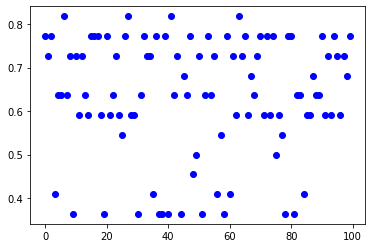

In [45]:
from statistics import mode
plt.plot(scores,'bo' )
print(np.max(scores)) 
print(np.min(scores))
print(np.median(scores))
print(mode(scores))

In [46]:
test_results

,mean,result,actual,Rate_NFL,true / false
Player,,,,,
Patrick Mahomes,0.25,0,1,109.6,False
Deshaun Watson,0.56,1,1,101.4,True
Lamar Jackson,0.57,1,1,98.9,True
Dak Prescott,0.67,1,1,97.0,True
Gardner Minshew,0.14,0,1,91.2,False
Nick Mullens,0.62,1,1,90.8,True
Drew Lock,0.61,1,1,89.7,True
Jared Goff,0.65,1,1,87.9,True
Daniel Jones,0.13,0,1,87.7,False


In [47]:
model_score_100_iterations = test_results['true / false'].value_counts()[1] / len(test_results)
model_score_100_iterations

0.8181818181818182

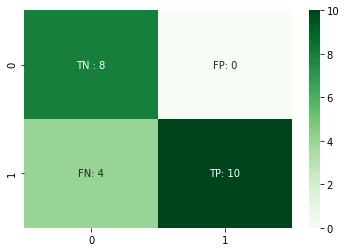

In [48]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(test_results['actual'], test_results['result']))
labels = np.array([['TN : ' + str(cm[0][0]), 'FP: ' + str(cm[1][0])], ['FN: ' + str(cm[0][1]), 'TP: ' + str(cm[1][1])]])
sns.heatmap(cm, annot=labels, fmt='', cmap='Greens')

In [49]:
test_results.actual.value_counts()

1    14
0     8
Name: actual, dtype: int64

In [50]:
feature_importances = pd.Series(dt.feature_importances_, index=X_test_rate.columns).sort_values(ascending=False)
feature_importances

Cmp_College     0.410863
Pct             0.347966
Y/A_College     0.241171
Yds_College     0.000000
TD_College      0.000000
Rate_College    0.000000
Int_College     0.000000
G_College       0.000000
Att_College     0.000000
AY/A_College    0.000000
dtype: float64

In [53]:
print('Yards Per Attempt Modeling')
print('YPA DummyClassifier Score: ' + str(dummy_score_ypa))
print('YPA Logistic Regression 3-Fold Cross-Validation Score, all features: ' + str(cv3_logreg_1))
print('YPA Logistic Regression 5-Fold Cross-Validation Score, all features: ' + str(cv5_logreg_1))
print('=' * 100)
print('YPA Logistic Regression 3-Fold Cross-Validation Score, Reduced Features: ' + str(cv3_logreg_2))
print('YPA Logistic Regression 5-Fold Cross-Validation Score, Reduced Features: ' + str(cv5_logreg_2))
print('=' * 100)
print('YPA Logistic Regression with Parameter Tuning Test Score: ' + str(logreg3_test_score))
print('=' * 100)
print('YPA DecisionTree 3-Fold Cross-Validation Score: ' + str(cv3_dt_1))
print('YPA DecisionTree 5-Fold Cross-Validation Score: ' + str(cv5_dt_1))
print('YPA DecisionTree with Parameter Tuning Test Score: ' + str(dt_test_score))
print('='*100)
print('='*100)
print('Passer Rating Modeling')
print('Passer Rating DummyClassifier Score: ' + str(dummy_score_rate))
print('Passer Rating Logistic Regression 3-Fold Cross-Validation Score, all features: ' + str(cv3_logreg_1_rate))
print('Passer Rating Logistic Regression 5-Fold Cross-Validation Score, all features: ' + str(cv5_logreg_1_rate))
print('=' * 100)
print('Passer Rating Logistic Regression 3-Fold Cross-Validation Score, Reduced Features: ' + str(cv3_logreg_2_rate))
print('Passer Rating Logistic Regression 5-Fold Cross-Validation Score, Reduced Features: ' + str(cv5_logreg_2_rate))
print('=' * 100)
print('Passer Rating Logistic Regression with Parameter Tuning Test Score: ' + str(logreg_test_score_rate))
print('=' * 100)
print('Passer Rating DecisionTree 3-Fold Cross-Validation Score: ' + str(cv3_dt_1_rate))
print('Passer Rating DecisionTree 5-Fold Cross-Validation Score: ' + str(cv5_dt_1_rate))
print('=' *100)
print('Passer Rating DecisionTree 3-Fold Cross-Validation Score, Parameter Tuning: ' + str(cv3_dt_2_rate))
print('Passer Rating DecisionTree 5-Fold Cross-Validation Score, Parameter Tuning: ' + str(cv5_dt_2_rate))
print('Passer Rating DecisionTree with Parameter Tuning Test Score: ' + str(dt_test_score_rate))
print('=' * 100)
print('100 Iterations of Model: ' + str(model_score_100_iterations))

Yards Per Attempt Modeling
YPA DummyClassifier Score: 0.6046511627906976
YPA Logistic Regression 3-Fold Cross-Validation Score, all features: 0.689922480620155
YPA Logistic Regression 5-Fold Cross-Validation Score, all features: 0.6975384615384616
YPA Logistic Regression 3-Fold Cross-Validation Score, Reduced Features: 0.6666666666666666
YPA Logistic Regression 5-Fold Cross-Validation Score, Reduced Features: 0.6735384615384615
YPA Logistic Regression with Parameter Tuning Test Score: 0.5
YPA DecisionTree 3-Fold Cross-Validation Score: 0.6046511627906976
YPA DecisionTree 5-Fold Cross-Validation Score: 0.536
YPA DecisionTree with Parameter Tuning Test Score: 0.5909090909090909
Passer Rating Modeling
Passer Rating DummyClassifier Score: 0.6666666666666666
Passer Rating Logistic Regression 3-Fold Cross-Validation Score, all features: 0.6356589147286822
Passer Rating Logistic Regression 5-Fold Cross-Validation Score, all features: 0.6203076923076923
Passer Rating Logistic Regression 3-Fold